# SynFlow Sanity-Check — VGG-16-BN on CIFAR-100

Reproducing the pruning-at-init comparison from *Pruning neural networks without any data by iteratively conserving synaptic flow* (Tanaka et al., NeurIPS 2020), **Appendix 13.3 / Figure 3**.

| Setting | Value |
|---|---|
| **Architecture** | VGG-16-BN (CIFAR variant, batch normalization) |
| **Dataset** | CIFAR-100 |
| **Initialization** | Kaiming Normal (weights); biases = 0 |
| **Prunable params** | All Conv2d + Linear weights (no biases, no BN) |
| **Pruning methods** | SynFlow, Random, Magnitude, SNIP, GraSP |
| **SynFlow iterations** | 100, exponential schedule ρ^{−k/n} |
| **Compression ratios ρ** | 10^α,  α ∈ {1, 1.5, 2, 2.5} (sanity subset) |
| **Optimizer** | SGD, momentum 0.9, weight decay 1e-4 |
| **LR schedule** | 0.1 → ×0.1 at epochs 60, 120 |

> **Sanity-check mode**: epochs = **10**, single seed, 7 ρ values.  
> Increase `EPOCHS` and add seeds for the full reproduction.

## 1 — Imports

In [1]:
import sys, os, copy, json, time, math
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

# Project imports
sys.path.append(os.path.abspath('../src'))
from model import vgg16, count_parameters
from synflow import synflow_pruning, apply_synflow_masks, get_synflow_sparsity
from train import train_epochs, evaluate
from util import apply_masks_to_model, create_mask_apply_fn, set_seed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2 — Configuration

In [2]:
# ── Sanity-check config ──────────────────────────────────────────
# Increase EPOCHS to 160 and SEEDS to [42, 43, 44] for the full run.

EPOCHS       = 50          # 160 for full reproduction
SEEDS        = [42]        # [42, 43, 44] for 3 runs
BATCH_SIZE   = 128
LR           = 0.1
MOMENTUM     = 0.9
WEIGHT_DECAY = 1e-4
LR_MILESTONES = [20, 37]
LR_GAMMA     = 0.1

# Compression ratios (paper sweeps α ∈ [0, 0.25, …, 4] → ρ = 10^α)
# Sanity-check subset: 7 points
ALPHAS = [1.0, 1.5, 2.0, 2.5]
RHOS   = [10**a for a in ALPHAS]

# Methods to compare
METHODS = ['synflow', 'random', 'magnitude', 'snip', 'grasp']

# SNIP / GraSP data budget
SNIP_GRASP_SAMPLES = 1000   # total samples from CIFAR-100

INPUT_SHAPE = (3, 32, 32)
NUM_CLASSES = 100
SYNFLOW_ITERS = 100
RESULTS_DIR = '../results/synflow_sanity'

print("=" * 60)
print("SANITY-CHECK CONFIGURATION")
print("=" * 60)
print(f"  Model          : VGG-16-BN")
print(f"  Dataset        : CIFAR-100")
print(f"  Epochs         : {EPOCHS}")
print(f"  Seeds          : {SEEDS}")
print(f"  Methods        : {METHODS}")
print(f"  ρ values       : {[f'{r:.2f}' for r in RHOS]}")
print(f"  α values       : {ALPHAS}")
print("=" * 60)

SANITY-CHECK CONFIGURATION
  Model          : VGG-16-BN
  Dataset        : CIFAR-100
  Epochs         : 50
  Seeds          : [42]
  Methods        : ['synflow', 'random', 'magnitude', 'snip', 'grasp']
  ρ values       : ['10.00', '31.62', '100.00', '316.23']
  α values       : [1.0, 1.5, 2.0, 2.5]


## 3 — Data loaders

In [3]:
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = torchvision.datasets.CIFAR100(root='../data', train=True,
                                          download=True, transform=train_transform)
test_ds  = torchvision.datasets.CIFAR100(root='../data', train=False,
                                          download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"CIFAR-100  Train: {len(train_ds):,}  Test: {len(test_ds):,}")

100%|████████████████████████████████████████| 169M/169M [00:03<00:00, 44.0MB/s]


CIFAR-100  Train: 50,000  Test: 10,000


## 4 — Baseline scoring functions

Five pruning-at-init strategies, all returning `Dict[str, np.ndarray]` masks:

| Method | Score | Mode | Data-free? |
|---|---|---|---|
| **SynFlow** | ∂R/∂θ ⊙ θ  (iterative, 100 rounds) | eval | ✓ |
| **Random** | Gaussian i.i.d. | — | ✓ |
| **Magnitude** | \|θ\| | — | ✓ |
| **SNIP** | \|∂L/∂θ ⊙ θ\| on one mini-batch | train | ✗ |
| **GraSP** | −(H ∂L/∂θ) ⊙ θ | train | ✗ |

In [4]:
# ── Helper: create a fresh VGG-16-BN with Kaiming init ──────────

def make_model(seed):
    """Return a freshly initialised VGG-16-BN for CIFAR-100."""
    set_seed(seed)
    model = vgg16(num_classes=NUM_CLASSES, batch_norm=True).to(device)
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    return model


# ── Generic one-shot masking from per-param scores ──────────────

def _scores_to_masks(scores: dict, rho: float) -> dict:
    """Global threshold: keep top 1/ρ fraction of scores (by magnitude)."""
    keep_ratio = 1.0 / rho
    all_s = torch.cat([s.view(-1) for s in scores.values()])
    n = all_s.numel()
    k = max(int(keep_ratio * n), 1)
    if k < n:
        thr, _ = torch.kthvalue(all_s.view(-1), n - k + 1)
    else:
        thr = torch.tensor(-float('inf'))
    masks = {}
    for name, s in scores.items():
        masks[name] = (s >= thr).float().numpy()
    return masks


# ── Random pruning ──────────────────────────────────────────────

def random_pruning(model, rho, seed=0):
    """Score = i.i.d. Gaussian → global top-1/ρ mask."""
    rng = torch.Generator().manual_seed(seed)
    scores = {}
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            scores[name] = torch.randn(module.weight.shape, generator=rng).abs()
    return _scores_to_masks(scores, rho)


# ── Magnitude pruning ──────────────────────────────────────────

def magnitude_pruning(model, rho):
    """Score = |θ| → global top-1/ρ mask."""
    scores = {}
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            scores[name] = module.weight.data.detach().abs().cpu()
    return _scores_to_masks(scores, rho)


# ── SNIP  (|∂L/∂θ ⊙ θ|, single forward-backward in train mode) ─

def snip_pruning(model, rho, dataloader, num_samples=1000):
    """SNIP: connection sensitivity |∂L/∂(θ⊙1)| ≈ |g⊙θ|."""
    net = copy.deepcopy(model).to(device)
    net.train()                         # paper: train mode (Appendix 13.1.1)
    net.zero_grad()

    # Collect a single large batch
    imgs, lbls = [], []
    for x, y in dataloader:
        imgs.append(x); lbls.append(y)
        if sum(i.size(0) for i in imgs) >= num_samples:
            break
    imgs = torch.cat(imgs)[:num_samples].to(device)
    lbls = torch.cat(lbls)[:num_samples].to(device)

    out = net(imgs)
    loss = F.cross_entropy(out, lbls)
    loss.backward()

    scores = {}
    for name, module in net.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.weight.grad is not None:
                scores[name] = (module.weight.grad * module.weight.data).detach().abs().cpu()
    return _scores_to_masks(scores, rho)


# ── GraSP  (−Hg ⊙ θ, in train mode) ───────────────────────────

def grasp_pruning(model, rho, dataloader, num_samples=1000, T=200.0):
    """GraSP: gradient signal preservation score −(Hg)⊙θ."""
    net = copy.deepcopy(model).to(device)
    net.train()                         # train mode (Appendix 13.1.1)
    net.zero_grad()

    weights = [m.weight for m in net.modules()
               if isinstance(m, (nn.Conv2d, nn.Linear))]
    for w in weights:
        w.requires_grad_(True)

    # Collect data
    imgs, lbls = [], []
    for x, y in dataloader:
        imgs.append(x); lbls.append(y)
        if sum(i.size(0) for i in imgs) >= num_samples:
            break
    imgs = torch.cat(imgs)[:num_samples].to(device)
    lbls = torch.cat(lbls)[:num_samples].to(device)
    N = imgs.size(0)

    # ---- first-order gradient g (no graph) ----
    out1 = net(imgs[:N//2]) / T
    loss1 = F.cross_entropy(out1, lbls[:N//2])
    g = list(autograd.grad(loss1, weights))

    out2 = net(imgs[N//2:]) / T
    loss2 = F.cross_entropy(out2, lbls[N//2:])
    g2 = autograd.grad(loss2, weights, create_graph=False)
    g = [gi + g2i for gi, g2i in zip(g, g2)]

    # ---- Hg via z = gᵀ g_f ----
    out_f = net(imgs[:N//2]) / T
    loss_f = F.cross_entropy(out_f, lbls[:N//2])
    g_f = autograd.grad(loss_f, weights, create_graph=True)
    z = sum((gi.data * gfi).sum() for gi, gfi in zip(g, g_f))
    z.backward()

    out_f2 = net(imgs[N//2:]) / T
    loss_f2 = F.cross_entropy(out_f2, lbls[N//2:])
    g_f2 = autograd.grad(loss_f2, weights, create_graph=True)
    z2 = sum((gi.data * gfi).sum() for gi, gfi in zip(g, g_f2))
    z2.backward()

    # Score = −θ ⊙ Hg  (higher = more important)
    scores = {}
    for name, module in net.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.weight.grad is not None:
                scores[name] = (-module.weight.data * module.weight.grad).detach().cpu()
    return _scores_to_masks(scores, rho)


print("Scoring functions defined: random, magnitude, snip, grasp, synflow")

Scoring functions defined: random, magnitude, snip, grasp, synflow


## 5 — Run sanity-check sweep

For each method × ρ × seed: prune → train → record test accuracy.  
Dense baseline (ρ = 1) is shared across methods.

In [5]:
def train_pruned(model, masks, seed):
    """Train a pruned (or dense) model and return best / final test acc."""
    set_seed(seed)
    apply_fn = create_mask_apply_fn(model) if masks is not None else None
    optimizer = optim.SGD(model.parameters(), lr=LR,
                          momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=LR_GAMMA)
    criterion = nn.CrossEntropyLoss()

    t0 = time.time()
    history = train_epochs(
        model=model, train_loader=train_loader, test_loader=test_loader,
        criterion=criterion, optimizer=optimizer, num_epochs=EPOCHS,
        device=device, scheduler=scheduler, masks=masks,
        apply_mask_fn=apply_fn, verbose=False,
    )
    elapsed = time.time() - t0
    best = max(history['test_accs'])
    final = history['final_test_acc']
    return best, final, elapsed, history


# ── Main loop ───────────────────────────────────────────────────
# results[method][rho] = list of (best_acc, final_acc) over seeds

results = {m: {} for m in METHODS}
all_histories = {m: {} for m in METHODS}  # for plotting curves

total_runs = len(METHODS) * len(RHOS) * len(SEEDS)
run_idx = 0

for seed in SEEDS:
    for rho in RHOS:
        alpha = math.log10(rho)
        sparsity = 1 - 1/rho if rho > 1 else 0.0

        for method in METHODS:
            run_idx += 1
            tag = f"[{run_idx}/{total_runs}] {method:>10s}  ρ={rho:>8.2f} (α={alpha:.2f}, s={sparsity:.1%})  seed={seed}"
            print(f"\n{'─'*70}\n{tag}")

            model = make_model(seed)

            # ── Pruning ──
            t_prune = time.time()
            masks = None
            if rho == 1.0:
                # Dense baseline — no pruning
                pass
            elif method == 'synflow':
                masks = synflow_pruning(model, device, rho=rho,
                                        num_iters=SYNFLOW_ITERS,
                                        input_shape=INPUT_SHAPE)
                apply_synflow_masks(model, masks)
            elif method == 'random':
                masks = random_pruning(model, rho, seed=seed)
                apply_synflow_masks(model, masks)
            elif method == 'magnitude':
                masks = magnitude_pruning(model, rho)
                apply_synflow_masks(model, masks)
            elif method == 'snip':
                masks = snip_pruning(model, rho, train_loader,
                                     num_samples=SNIP_GRASP_SAMPLES)
                # snip_pruning returns masks but doesn't apply them
                apply_synflow_masks(model, masks)
            elif method == 'grasp':
                masks = grasp_pruning(model, rho, train_loader,
                                      num_samples=SNIP_GRASP_SAMPLES)
                apply_synflow_masks(model, masks)
            prune_time = time.time() - t_prune

            if masks is not None:
                sp = get_synflow_sparsity(masks)
                print(f"  Pruned in {prune_time:.1f}s — actual sparsity {sp['overall']:.2%}")
            else:
                print(f"  Dense (no pruning)")

            # ── Train ──
            best, final, train_time, hist = train_pruned(model, masks, seed)
            print(f"  Train {EPOCHS} ep in {train_time:.1f}s — best {best:.2f}%, final {final:.2f}%")

            results[method].setdefault(rho, []).append((best, final))
            all_histories[method].setdefault(rho, []).append(hist)

print(f"\n{'='*70}\nAll {total_runs} runs complete.\n{'='*70}")


──────────────────────────────────────────────────────────────────────
[1/20]    synflow  ρ=   10.00 (α=1.00, s=90.0%)  seed=42
  Pruned in 37.2s — actual sparsity 90.00%
  Train 50 ep in 1367.6s — best 47.85%, final 47.85%

──────────────────────────────────────────────────────────────────────
[2/20]     random  ρ=   10.00 (α=1.00, s=90.0%)  seed=42
  Pruned in 0.5s — actual sparsity 90.00%
  Train 50 ep in 1393.5s — best 61.66%, final 61.40%

──────────────────────────────────────────────────────────────────────
[3/20]  magnitude  ρ=   10.00 (α=1.00, s=90.0%)  seed=42
  Pruned in 0.3s — actual sparsity 90.00%
  Train 50 ep in 1397.7s — best 49.61%, final 49.48%

──────────────────────────────────────────────────────────────────────
[4/20]       snip  ρ=   10.00 (α=1.00, s=90.0%)  seed=42
  Pruned in 1.1s — actual sparsity 90.00%
  Train 50 ep in 1401.3s — best 54.02%, final 54.02%

──────────────────────────────────────────────────────────────────────
[5/20]      grasp  ρ=   10.00 (

## 6 — Visualise: Accuracy vs Compression Ratio ρ

Reproduces the paper's Figure 3 style — log-scale x-axis (ρ = 10^α), one line per method.

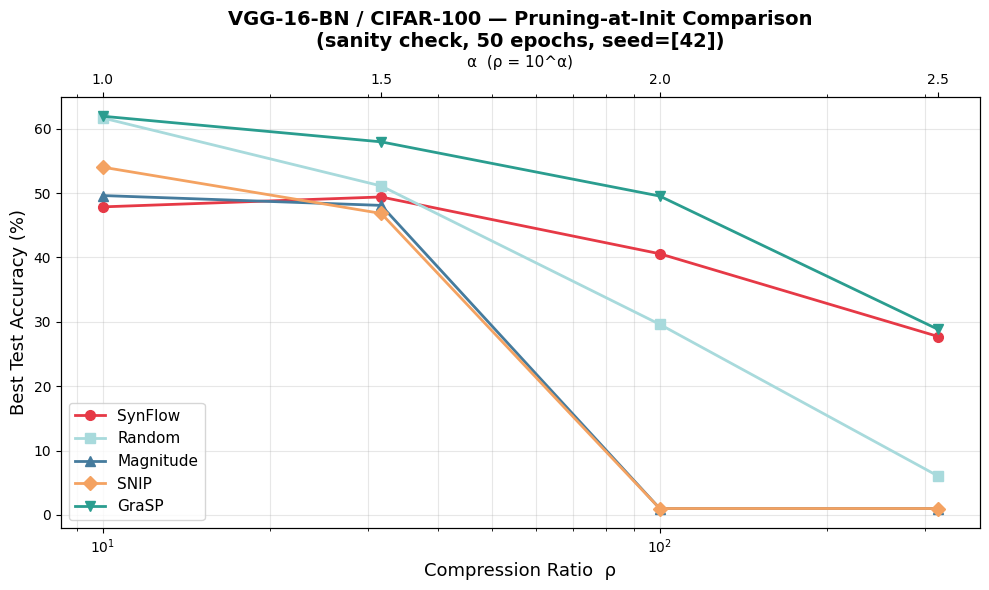


SUMMARY — VGG-16-BN / CIFAR-100  (50 epochs)
         ρ      α    Sparsity     SynFlow      Random   Magnitude        SNIP       GraSP
------------------------------------------------------------------------------------------
     10.00   1.00      90.0%      47.85%      61.66%      49.61%      54.02%      61.93%
     31.62   1.50      96.8%      49.39%      51.10%      48.08%      46.83%      57.95%
    100.00   2.00      99.0%      40.57%      29.61%       1.00%       1.00%      49.53%
    316.23   2.50      99.7%      27.71%       6.03%       1.00%       1.00%      28.81%

Results saved to ../results/synflow_sanity/sanity_20260221_231552.json


In [6]:
method_styles = {
    'synflow':   {'color': '#E63946', 'marker': 'o', 'label': 'SynFlow'},
    'random':    {'color': '#A8DADC', 'marker': 's', 'label': 'Random'},
    'magnitude': {'color': '#457B9D', 'marker': '^', 'label': 'Magnitude'},
    'snip':      {'color': '#F4A261', 'marker': 'D', 'label': 'SNIP'},
    'grasp':     {'color': '#2A9D8F', 'marker': 'v', 'label': 'GraSP'},
}

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for method in METHODS:
    rho_vals = sorted(results[method].keys())
    mean_accs, min_accs, max_accs = [], [], []
    for r in rho_vals:
        bests = [b for b, _ in results[method][r]]
        mean_accs.append(np.mean(bests))
        min_accs.append(np.min(bests))
        max_accs.append(np.max(bests))

    sty = method_styles[method]
    ax.plot(rho_vals, mean_accs, marker=sty['marker'], color=sty['color'],
            label=sty['label'], linewidth=2, markersize=7)
    if len(SEEDS) > 1:
        ax.fill_between(rho_vals, min_accs, max_accs,
                        color=sty['color'], alpha=0.15)

ax.set_xscale('log')
ax.set_xlabel('Compression Ratio  ρ', fontsize=13)
ax.set_ylabel('Best Test Accuracy (%)', fontsize=13)
ax.set_title('VGG-16-BN / CIFAR-100 — Pruning-at-Init Comparison\n'
             f'(sanity check, {EPOCHS} epochs, seed={SEEDS})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower left')
ax.grid(True, alpha=0.3, which='both')

# Secondary x-axis showing α = log10(ρ)
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
alpha_ticks = [10**a for a in ALPHAS]
ax2.set_xticks(alpha_ticks)
ax2.set_xticklabels([f'{a:.1f}' for a in ALPHAS])
ax2.set_xlabel('α  (ρ = 10^α)', fontsize=11)

plt.tight_layout()
os.makedirs(RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(RESULTS_DIR, 'sanity_check_vgg16_cifar100.png'),
            dpi=150, bbox_inches='tight')
plt.show()

# ── Summary table ───────────────────────────────────────────────
print(f"\n{'='*90}")
print(f"SUMMARY — VGG-16-BN / CIFAR-100  ({EPOCHS} epochs)")
print(f"{'='*90}")
header = f"{'ρ':>10s}  {'α':>5s}  {'Sparsity':>10s}"
for m in METHODS:
    header += f"  {method_styles[m]['label']:>10s}"
print(header)
print("-" * 90)
for rho in sorted(RHOS):
    alpha = math.log10(rho) if rho > 0 else 0
    sp = 1 - 1/rho if rho > 1 else 0
    row = f"{rho:>10.2f}  {alpha:>5.2f}  {sp:>9.1%}"
    for m in METHODS:
        bests = [b for b, _ in results[m].get(rho, [(0, 0)])]
        row += f"  {np.mean(bests):>9.2f}%"
    print(row)

# ── Save JSON ───────────────────────────────────────────────────
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(RESULTS_DIR, f"sanity_{timestamp}.json")
serialisable = {}
for m in METHODS:
    serialisable[m] = {}
    for rho, vals in results[m].items():
        serialisable[m][str(rho)] = {
            'rho': rho,
            'alpha': math.log10(rho) if rho > 0 else 0,
            'sparsity': 1 - 1/rho if rho > 1 else 0,
            'best_accs': [b for b, _ in vals],
            'final_accs': [f for _, f in vals],
        }
with open(save_path, 'w') as f:
    json.dump(serialisable, f, indent=2)
print(f"\nResults saved to {save_path}")